## Простейший градиентный спуск для перцептрона

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from autograd import grad

In [ ]:
def perceptron(x, weight, derivative_by=None):
  if not derivative_by:
    return np.tanh(x * weight)
  if derivative_by == "x":
    return (1 - np.tanh(x * weight) ** 2) * weight
  if derivative_by == "weight":
    return (1 - np.tanh(x * weight) ** 2) * x

def loss(y_predicted, y_true, derivative=False):
  if not derivative:
    return (y_predicted - y_true) ** 2
  return 2 * (y_predicted - y_true)

In [ ]:
x = np.linspace(-3, 3, 100)

y = np.tanh(-6 * x)

noise = np.random.normal(0, 0.01, len(y))
y += noise

data = list(zip(x, y))

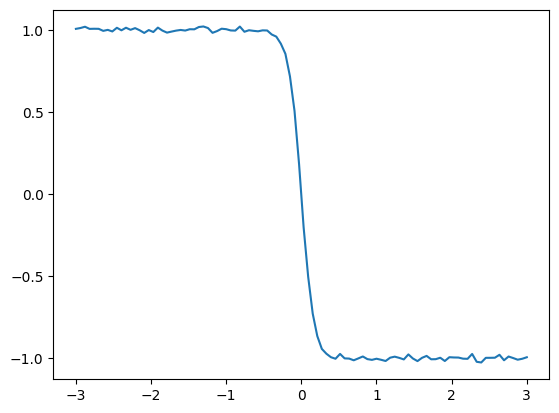

In [ ]:
plt.plot(x, y)
plt.show()

In [ ]:
weight = 0.1

lr = 0.01

N_EPOCHES = 10000

history = []

for _ in range(N_EPOCHES):
  for xi, yi in data:
    prediction = perceptron(xi, weight)
    curent_loss = loss(prediction, yi)
    weight -= lr * loss(prediction, yi, derivative=True) * perceptron(xi, weight, derivative_by="weight")
    history.append((curent_loss, xi, yi, prediction, weight))

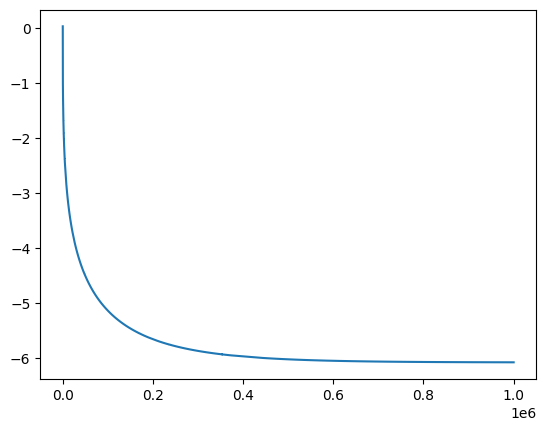

In [ ]:
weights_changes = list(np.array(history)[:, 4])
plt.plot(list(range(len(weights_changes))), weights_changes)
plt.show()

## Регуляризация

### Исследуемая функция

In [ ]:
x1 = np.linspace(-3, 0, 80)
y1 = np.tanh(5.5 * x1)  # Перебрать значения: 0.5

x2 = np.linspace(0, 3, 20)
y2 = np.tanh(64 * x2)

x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((y1, y2), axis=0)

noise = np.random.normal(0, 0.005, len(y))
y += noise

data = list(zip(x, y))

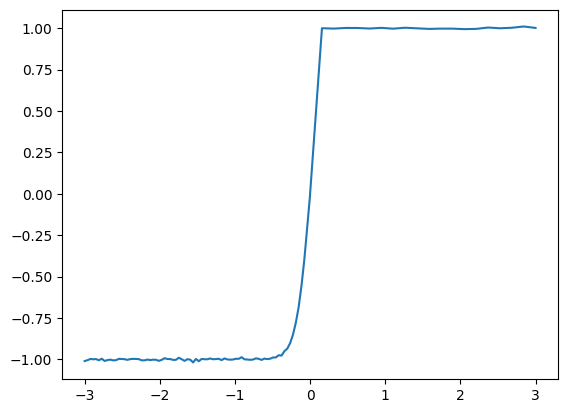

In [ ]:
plt.plot(x, y)
plt.show()

In [ ]:
weight = 0.1

lr = 0.05

N_EPOCHES = 1000

history = []

for _ in range(N_EPOCHES):
  for xi, yi in data:
    prediction = perceptron(xi, weight)
    curent_loss = loss(prediction, yi)
    weight -= lr * loss(prediction, yi, derivative=True) * perceptron(xi, weight, derivative_by="weight")
    history.append((curent_loss, xi, yi, prediction, weight))

In [ ]:
weight

6.106751397313553

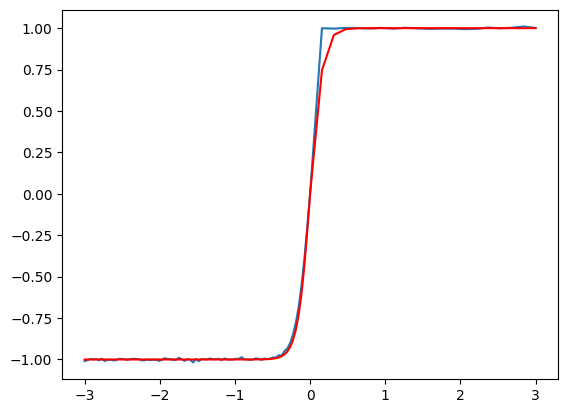

In [ ]:
plt.plot(x, y, label="Original")
plt.plot(x, [perceptron(xi, weight) for xi in x], color="red", label="Prediction")
plt.show()

### Классическая

In [ ]:
def regularization(weight, reg_power, derivative=False):
  if not derivative:
    return reg_power * weight ** 2
  return 2 * reg_power * weight

In [ ]:
weight = 0.1

lr = 0.05
reg_power = 0.001

N_EPOCHES = 1000

history = []

for _ in range(N_EPOCHES):
  for xi, yi in data:
    prediction = perceptron(xi, weight)
    curent_loss = loss(prediction, yi) + regularization(weight, reg_power)
    weight -= lr * (loss(prediction, yi, derivative=True) * perceptron(xi, weight, derivative_by="weight") + regularization(weight, reg_power, derivative=True))
    history.append((curent_loss, xi, yi, prediction, weight))

In [ ]:
weight

3.2926409270063663

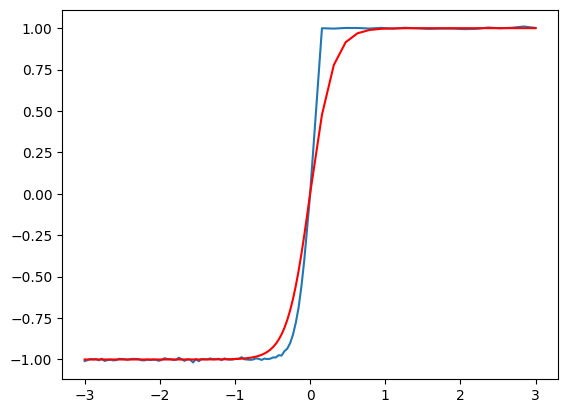

In [ ]:
plt.plot(x, y, label="Original")
plt.plot(x, [perceptron(xi, weight) for xi in x], color="red", label="Prediction")
plt.show()

### По длине вектора градиента функции ошибки от начальных фичей

In [ ]:
import autograd.numpy as np

def x_grad_regularization(x, weight, real_y, reg_power, derivative=False):
  if not derivative:
    return 2 * reg_power * abs((np.tanh(weight * x) - real_y) * (1 - np.tanh(weight * x) ** 2) * weight)
  return grad(x_grad_regularization, argnum=1)(x, weight, real_y, reg_power)

In [ ]:
weight = 0.1

lr = 0.05
reg_power = 0.001

N_EPOCHES = 1000

history = []

for n_epoch in range(N_EPOCHES):
  for xi, yi in data:
    prediction = perceptron(xi, weight)
    curent_loss = loss(prediction, yi) + x_grad_regularization(xi, weight, yi, reg_power)
    weight -= lr * (loss(prediction, yi, derivative=True) * perceptron(xi, weight, derivative_by="weight") + x_grad_regularization(xi, weight, yi, reg_power, derivative=True))
    history.append((curent_loss, xi, yi, prediction, weight))

weight

6.080532098606125

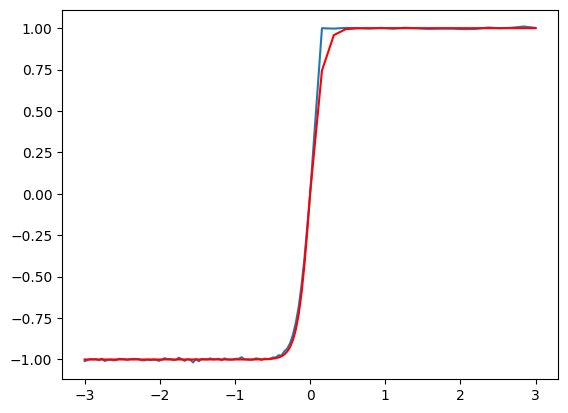

In [ ]:
plt.plot(x, y, label="Original")
plt.plot(x, [perceptron(xi, weight) for xi in x], color="red", label="Prediction")
plt.show()

### Результаты

Классическая регуляризация - просто занижение, работает агрессивно. По длине вектораградиента занижение не агрессивно, но лучше приближает параметр, чем при отсутствующей регуляризации.

## MLP

In [ ]:
from abc import ABC, abstractmethod


class BaseLayer(ABC):
  @abstractmethod
  def forward(self, *args, **kwargs):
    ...


  @abstractmethod
  def backward(self, *args, **kwargs):
    ...


class StubLayer(BaseLayer):
  def __init__(self):
    self.value = None
    self.following_derivative_chain = None

  def set_value(self, value: float) -> None:
    self.value = value

  def forward(self) -> float:
    return self.value

  def backward(self) -> None:
    ...


class LinearLayer(BaseLayer):
  def __init__(
      self,
      func,
      deriv,
      inputs: list[BaseLayer],
      alpha: float = 0.001,
    ):
    self.func = func
    self.deriv = deriv
    self.inputs = inputs
    self.alpha = alpha

    self.weights = np.random.rand(len(inputs))
    self.b = np.random.rand()

    self.last_input = None
    self.following_derivative_chain = None

  def forward(self) -> float:
    self.last_input = np.array(
        [input_layer.forward() for input_layer in self.inputs]
    )
    return self.func(sum(self.weights * self.last_input) + self.b)

  def backward(self) -> None:
    target_gradient = self.deriv(
        self.weights, self.last_input
    ) * self.following_derivative_chain
    self.weights -= self.alpha * target_gradient
    for input_layer, chain_derivative in zip(self.inputs, target_gradient):
      input_layer.following_derivative_chain = chain_derivative
      input_layer.backward()

In [ ]:
def tanh_deriv(weight, x) -> float:
  return (1 - np.tanh(x * weight) ** 2) * x

def loss(y_predicted, y_true, derivative=False):
  if not derivative:
    return
  return 2 * (y_predicted - y_true)

In [ ]:
from random import random

input_layer = StubLayer()
front_layers = [
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
    ),
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
    )
]
middle_layers = [
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
    ),
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
    ),
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
    )
]
output_layer = LinearLayer(
    func=np.tanh,
    deriv=tanh_deriv,
    inputs=middle_layers,
)


def loss(y_predicted: float, y_true: float) -> float:
  return (y_predicted - y_true) ** 2

def loss_derivative(y_predicted: float, y_true: float) -> float:
  return 2 * (y_predicted - y_true)

for epoch in range(10_000):
  for train_x, train_y in zip(x, y):
    input_layer.set_value(train_x)
    predicted_y = output_layer.forward()
    if random() < 0.0001:
      print(f"Loss: {loss(predicted_y, train_y)}")
    output_layer.following_derivative_chain = loss_derivative(
        predicted_y, train_y
    )
    output_layer.backward()

Loss: 0.2071001817793554
Loss: 0.4172163176321503
Loss: 0.4354429059092111
Loss: 2.9129406282895385
Loss: 1.7096802393661894
Loss: 0.35480423944402323
Loss: 0.20518185022950117
Loss: 1.8621871153978613
Loss: 2.8837855722389745
Loss: 0.7428802918152135
Loss: 2.744888045356671
Loss: 2.9046080549756823
Loss: 2.892367314892724
Loss: 0.13623824675388624
Loss: 0.5681119729323957
Loss: 2.888755842727487
Loss: 0.6460227140786166
Loss: 2.874241369562983
Loss: 0.7076879138584453
Loss: 1.977479635937183
Loss: 2.929618136892449
Loss: 2.818878224866768
Loss: 2.9143518981941208
Loss: 2.9164659537163105
Loss: 2.9544864469998284
Loss: 0.8282938079654194
Loss: 2.6566684342612708
Loss: 2.127747770948391
Loss: 0.8779356194796103
Loss: 2.7158215266632317
Loss: 0.5150613031257159
Loss: 1.257369662741984
Loss: 1.706914581527649
Loss: 0.4997911769509477
Loss: 2.94618614620405
Loss: 0.5320025685928188
Loss: 2.9686946157471543
Loss: 0.3068925548019238
Loss: 0.5825404633154362
Loss: 0.6039862539800251
Loss: 2.0

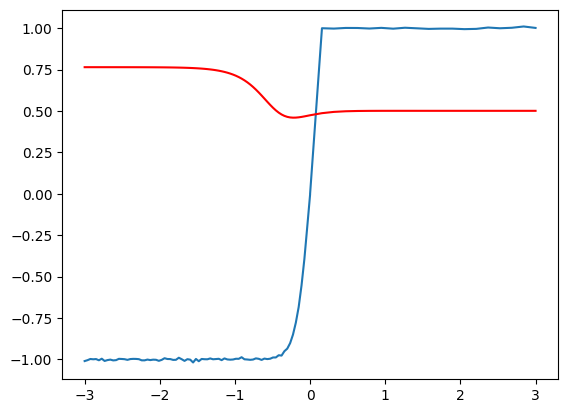

In [ ]:
predicted_ys = []
for train_x in x:
  input_layer.set_value(train_x)
  predicted_ys.append(output_layer.forward())

plt.plot(x, y, label="Original")
plt.plot(x, predicted_ys, color="red", label="Prediction")
plt.show()

**Важно:** берем регуляризацию с коэффом 0.01

In [ ]:
class LinearFieldLastLayer(LinearLayer):
  def backward(self, first_layer, first_layer_input) -> None:
    target_gradient = self.deriv(
        self.weights, self.last_input
    ) * self.following_derivative_chain
    def der(input):
      first_layer.set_value(first_layer_input)
      return self.forward()
    regul_addition = grad(der, argnum=0)(first_layer_input)
    if np.isnan(regul_addition).any():
      regul_addition = 0
    self.weights -= self.alpha * (target_gradient + 0.01 * regul_addition)
    for input_layer, chain_derivative in zip(self.inputs, target_gradient):
      input_layer.following_derivative_chain = chain_derivative
      input_layer.backward()

In [ ]:
input_layer = StubLayer()
front_layers = [
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
    ),
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
    )
]
middle_layers = [
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
    ),
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
    ),
    LinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
    )
]
output_layer = LinearFieldLastLayer(
    func=np.tanh,
    deriv=tanh_deriv,
    inputs=middle_layers,
)


for epoch in range(10_000):
  epoch_loss = 0
  for train_x, train_y in zip(x, y):
    input_layer.set_value(train_x)
    predicted_y = output_layer.forward()
    output_layer.following_derivative_chain = loss_derivative(
        predicted_y, train_y
    )
    output_layer.backward(input_layer, train_x)
    epoch_loss += loss(predicted_y, train_y)
  epoch_loss /= len(x)
  print(f"Loss: {epoch_loss}")

Выходные данные были обрезаны до нескольких последних строк (5000).
Loss: 0.7678167352281757
Loss: 0.7800950884875849
Loss: 0.792693173288939
Loss: 0.8056184775525899
Loss: 0.81887828035041
Loss: 0.8324796014869881
Loss: 0.8464291464700884
Loss: 0.8607332467786432
Loss: 0.8753977953942218
Loss: 0.8904281776318537
Loss: 0.9058291973893242
Loss: 0.9216049990316718
Loss: 0.937758985239705
Loss: 0.9542937312775185
Loss: 0.9712108962750405
Loss: 0.988511132274338
Loss: 1.0061939919528873
Loss: 1.0242578361083183
Loss: 1.0426997421651103
Loss: 1.0615154151379478
Loss: 1.0806991026536932
Loss: 1.1002435157864636
Loss: 1.1201397575903467
Loss: 1.140377261313121
Loss: 1.1609437403318814
Loss: 1.181825151859879
Loss: 1.2030056764229566
Loss: 1.2244677149877017
Loss: 1.2461919054345076
Loss: 1.268157159805459
Loss: 1.2903407234179058
Loss: 1.3127182565247384
Loss: 1.3352639387276175
Loss: 1.357950595823815
Loss: 1.3807498482045395
Loss: 1.4036322793441094
Loss: 1.426567622346336
Loss: 1.449524961

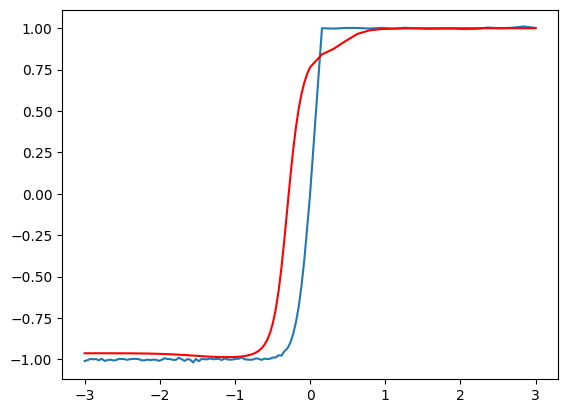

In [ ]:
predicted_ys = []
for train_x in x:
  input_layer.set_value(train_x)
  predicted_ys.append(output_layer.forward())

plt.plot(x, y, label="Original")
plt.plot(x, predicted_ys, color="red", label="Prediction")
plt.show()

### Равные начальные вектора

In [ ]:
class SavedLinearLayer(LinearLayer):
  def __init__(self, *args, **kwargs):
    init_weights = kwargs.pop("init_weights", None)
    weight_storage = kwargs.pop("weight_storage", None)
    super().__init__(*args, **kwargs)
    if init_weights is not None:
      self.weights = init_weights
    if weight_storage is not None:
      weight_storage.append(self.weights.copy())

In [ ]:
ws = []
input_layer = StubLayer()
front_layers = [
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
        weight_storage=ws,
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
        weight_storage=ws,
    )
]
middle_layers = [
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        weight_storage=ws,
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        weight_storage=ws,
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        weight_storage=ws,
    )
]
output_layer = SavedLinearLayer(
    func=np.tanh,
    deriv=tanh_deriv,
    inputs=middle_layers,
    weight_storage=ws,
)

ws

[array([0.77334515]),
 array([0.7443751]),
 array([0.69386174, 0.56134315]),
 array([0.3225988 , 0.99078499]),
 array([0.77835313, 0.87509655]),
 array([0.19503129, 0.08754102, 0.19945442])]

In [ ]:
for epoch in range(10_000):
  for train_x, train_y in zip(x, y):
    input_layer.set_value(train_x)
    predicted_y = output_layer.forward()
    if random() < 0.0001:
      print(f"Loss: {loss(predicted_y, train_y)}")
    output_layer.following_derivative_chain = loss_derivative(
        predicted_y, train_y
    )
    output_layer.backward()

Loss: 1.7070072242768903
Loss: 0.08216397595874969
Loss: 0.2152471943283086
Loss: 0.5753058214933773
Loss: 1.2602342053350717
Loss: 1.2493142969691238
Loss: 1.8475230688003152
Loss: 2.571083177724868
Loss: 0.029491293479303748
Loss: 0.1386910541456295
Loss: 1.2139517935852233
Loss: 1.167014020377913
Loss: 0.31069921594554256
Loss: 2.741360347406569
Loss: 1.2727547771862033
Loss: 1.1778695588439672
Loss: 2.4298986784336436
Loss: 0.24538337793106754
Loss: 1.588071402955949
Loss: 0.5011736359617133
Loss: 2.151348101589777
Loss: 2.4934541547936684
Loss: 1.86075175931287
Loss: 0.013043968103230733
Loss: 1.5694968221602401
Loss: 2.236094945816926
Loss: 2.2094251056160537
Loss: 2.220027249257013
Loss: 1.96802692054425
Loss: 1.092430002870461
Loss: 0.9304544648260935
Loss: 2.033878046835361
Loss: 0.8309787229060961
Loss: 1.226449760165351
Loss: 1.7633188380794051
Loss: 2.0106852421024795
Loss: 0.061617753564430604
Loss: 1.6365373766154108
Loss: 1.0651646021008188
Loss: 0.1206486216560516
Loss:

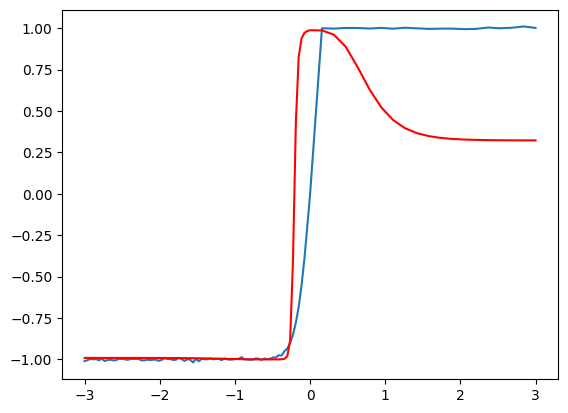

In [ ]:
predicted_ys = []
for train_x in x:
  input_layer.set_value(train_x)
  predicted_ys.append(output_layer.forward())

plt.plot(x, y, label="Original")
plt.plot(x, predicted_ys, color="red", label="Prediction")
plt.show()

In [ ]:
ws = [
    np.array([0.77334515]),
    np.array([0.7443751]),
    np.array([0.69386174, 0.56134315]),
    np.array([0.3225988 , 0.99078499]),
    np.array([0.77835313, 0.87509655]),
    np.array([0.19503129, 0.08754102, 0.19945442])
]

ws

[array([0.77334515]),
 array([0.7443751]),
 array([0.69386174, 0.56134315]),
 array([0.3225988 , 0.99078499]),
 array([0.77835313, 0.87509655]),
 array([0.19503129, 0.08754102, 0.19945442])]

In [ ]:
class SavedLinearFieldLastLayer(LinearFieldLastLayer):
  def __init__(self, *args, **kwargs):
    init_weights = kwargs.pop("init_weights")
    super().__init__(*args, **kwargs)
    self.weights = init_weights.copy()

In [ ]:
input_layer = StubLayer()
front_layers = [
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
        init_weights=ws[0],
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
        init_weights=ws[1],
    )
]
middle_layers = [
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        init_weights=ws[2],
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        init_weights=ws[3],
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        init_weights=ws[4],
    )
]
output_layer = SavedLinearFieldLastLayer(
    func=np.tanh,
    deriv=tanh_deriv,
    inputs=middle_layers,
    init_weights=ws[5],
)


for epoch in range(10_000):
  for train_x, train_y in zip(x, y):
    input_layer.set_value(train_x)
    predicted_y = output_layer.forward()
    output_layer.following_derivative_chain = loss_derivative(
        predicted_y, train_y
    )
    output_layer.backward(input_layer, train_x)
    if random() < 0.0001:
      print(f"Loss: {loss(predicted_y, train_y)}")

Loss: 1.5725037805822855
Loss: 1.7823389991669671
Loss: 1.4868825629766462
Loss: 1.504512337044351
Loss: 1.386113800293676
Loss: 1.6342513368897056
Loss: 0.043866470032356
Loss: 0.06670357225565622
Loss: 0.9650287412065758
Loss: 0.7628840707611971
Loss: 0.8819371412330472
Loss: 0.06744374164483045
Loss: 1.1542739172290086
Loss: 1.5278897888165903
Loss: 0.3228269162119388
Loss: 0.2213421372335823
Loss: 0.2707107409151497
Loss: 0.04212828682386361
Loss: 0.08358760497867966
Loss: 0.03488835237688471
Loss: 0.9502534705474285
Loss: 0.040164264040363426
Loss: 0.03361581299898175
Loss: 0.036583032414256506
Loss: 0.08985819309377231
Loss: 0.9461719802341165
Loss: 0.036635317070712124
Loss: 0.041316693702831656
Loss: 0.008773175238828783
Loss: 0.05569874713523891
Loss: 0.0068439597165401165
Loss: 0.07610692977956754
Loss: 0.0039523682713498475
Loss: 0.006850795092841605
Loss: 0.046298510659455436
Loss: 0.002846487670771317
Loss: 0.005036003187437375
Loss: 0.00198714846309927
Loss: 0.05262472064

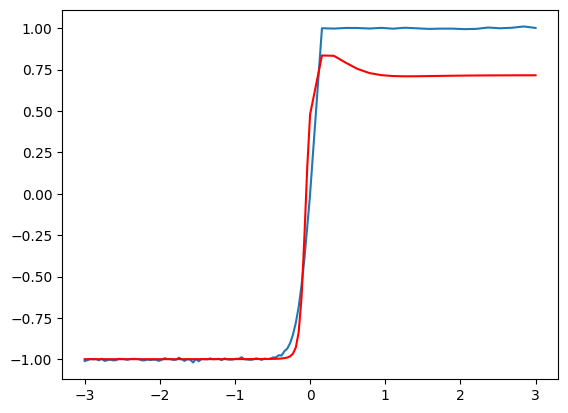

In [ ]:
predicted_ys = []
for train_x in x:
  input_layer.set_value(train_x)
  predicted_ys.append(output_layer.forward())

plt.plot(x, y, label="Original")
plt.plot(x, predicted_ys, color="red", label="Prediction")
plt.show()

### Равные начальные веса, больший вес регуляризации, графики лоссов, меньше эпох, под-ва точек (???)

In [ ]:
ws = []
input_layer = StubLayer()
front_layers = [
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
        weight_storage=ws,
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
        weight_storage=ws,
    )
]
middle_layers = [
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        weight_storage=ws,
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        weight_storage=ws,
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        weight_storage=ws,
    )
]
output_layer = SavedLinearLayer(
    func=np.tanh,
    deriv=tanh_deriv,
    inputs=middle_layers,
    weight_storage=ws,
)

ws

[array([0.66245906]),
 array([0.29644656]),
 array([0.47676269, 0.11524602]),
 array([0.94034523, 0.92187874]),
 array([0.45891915, 0.18697026]),
 array([0.0685998 , 0.40222312, 0.80761227])]

In [ ]:
for l in front_layers + middle_layers + [output_layer]:
  print(l.weights, end=", ")

[0.66245906], [0.29644656], [0.47676269 0.11524602], [0.94034523 0.92187874], [0.45891915 0.18697026], [0.0685998  0.40222312 0.80761227], 

In [ ]:
lossed_no = []
for epoch in range(7_500):
  epoch_loss, n_samples_in_epoch = 0, 0
  for train_x, train_y in zip(x, y):
    input_layer.set_value(train_x)
    predicted_y = output_layer.forward()
    epoch_loss += loss(predicted_y, train_y)
    n_samples_in_epoch += 1
    output_layer.following_derivative_chain = loss_derivative(
        predicted_y, train_y
    )
    output_layer.backward()

  av_epoch_loss = epoch_loss / n_samples_in_epoch
  lossed_no.append(av_epoch_loss)
  if random() < 0.01:
    print(f"Averge epoch loss with {n_samples_in_epoch} samples loss: {av_epoch_loss}")

Averge epoch loss with 100 samples loss: 1.8700188676847995
Averge epoch loss with 100 samples loss: 1.8327020108735375
Averge epoch loss with 100 samples loss: 1.8264601353192702
Averge epoch loss with 100 samples loss: 1.7441192599146265
Averge epoch loss with 100 samples loss: 1.7432164901151503
Averge epoch loss with 100 samples loss: 1.7426005983813044
Averge epoch loss with 100 samples loss: 1.7286041815951565
Averge epoch loss with 100 samples loss: 1.7245940396324113
Averge epoch loss with 100 samples loss: 1.7245633262532545
Averge epoch loss with 100 samples loss: 1.7242821262660335
Averge epoch loss with 100 samples loss: 1.7241126444963806
Averge epoch loss with 100 samples loss: 1.723588073160968
Averge epoch loss with 100 samples loss: 1.723537582741524
Averge epoch loss with 100 samples loss: 1.7263096181173225
Averge epoch loss with 100 samples loss: 1.727925394705546
Averge epoch loss with 100 samples loss: 1.7288297246023447
Averge epoch loss with 100 samples loss: 1.

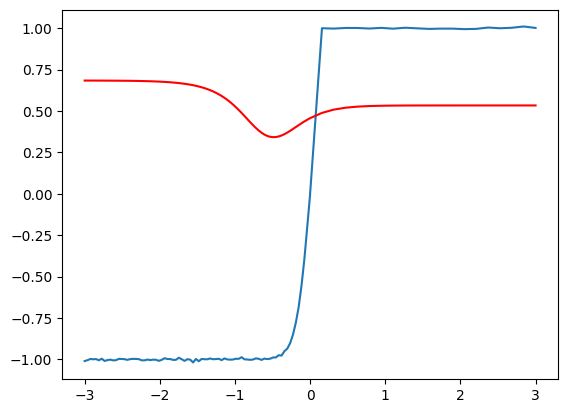

In [ ]:
predicted_ys = []
for train_x in x:
  input_layer.set_value(train_x)
  predicted_ys.append(output_layer.forward())

plt.plot(x, y, label="Original")
plt.plot(x, predicted_ys, color="red", label="Prediction")
plt.show()

In [ ]:
class WeightedLinearFieldLastLayer(SavedLinearFieldLastLayer):
  def backward(self, first_layer, first_layer_input, weight) -> None:
    target_gradient = self.deriv(
        self.weights, self.last_input
    ) * self.following_derivative_chain
    def der(input):
      first_layer.set_value(first_layer_input)
      return self.forward()
    regul_addition = grad(der, argnum=0)(first_layer_input)
    if np.isnan(regul_addition).any():
      regul_addition = 0
    self.weights -= self.alpha * (target_gradient + regul_addition)
    for input_layer, chain_derivative in zip(self.inputs, weight * target_gradient):
      input_layer.following_derivative_chain = chain_derivative
      input_layer.backward()

In [ ]:
input_layer = StubLayer()
front_layers = [
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
        init_weights=ws[0],
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=[input_layer],
        init_weights=ws[1],
    )
]
middle_layers = [
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        init_weights=ws[2],
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        init_weights=ws[3],
    ),
    SavedLinearLayer(
        func=np.tanh,
        deriv=tanh_deriv,
        inputs=front_layers,
        init_weights=ws[4],
    )
]
output_layer = WeightedLinearFieldLastLayer(
    func=np.tanh,
    deriv=tanh_deriv,
    inputs=middle_layers,
    init_weights=ws[5],
)

In [ ]:
for l in front_layers + middle_layers + [output_layer]:
  print(l.weights, end=", ")

[0.66245906], [0.29644656], [0.47676269 0.11524602], [0.94034523 0.92187874], [0.45891915 0.18697026], [0.0685998  0.40222312 0.80761227], 

In [ ]:
lossed_reg = []
for epoch in range(7_500):
  epoch_loss, n_samples_in_epoch = 0, 0
  for train_x, train_y in zip(x, y):
    input_layer.set_value(train_x)
    predicted_y = output_layer.forward()
    epoch_loss += loss(predicted_y, train_y)
    n_samples_in_epoch += 1
    output_layer.following_derivative_chain = loss_derivative(
        predicted_y, train_y
    )
    output_layer.backward(input_layer, train_x, 0.5)

  av_epoch_loss = epoch_loss / n_samples_in_epoch
  lossed_reg.append(av_epoch_loss)
  if random() < 0.01:
    print(f"Averge epoch loss with {n_samples_in_epoch} samples loss: {av_epoch_loss}")

/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Averge epoch loss with 100 samples loss: 0.3007011494535239
Averge epoch loss with 100 samples loss: 1.9340811107933598
Averge epoch loss with 100 samples loss: 1.9282048856788407
Averge epoch loss with 100 samples loss: 1.8406304014892383
Averge epoch loss with 100 samples loss: 1.7965873144522593
Averge epoch loss with 100 samples loss: 1.756174653149344
Averge epoch loss with 100 samples loss: 1.7526179339931443
Averge epoch loss with 100 samples loss: 1.7229824617782654
Averge epoch loss with 100 samples loss: 1.7195484628341662
Averge epoch loss with 100 samples loss: 1.6697744995419352
Averge epoch loss with 100 samples loss: 1.5744582751888665
Averge epoch loss with 100 samples loss: 1.481665189133369
Averge epoch loss with 100 samples loss: 1.4797275461031025
Averge epoch loss with 100 samples loss: 1.4205171017229952
Averge epoch loss with 100 samples loss: 1.3916939649691025
Averge epoch loss with 100 samples loss: 1.3910862244815474
Averge epoch loss with 100 samples loss: 1

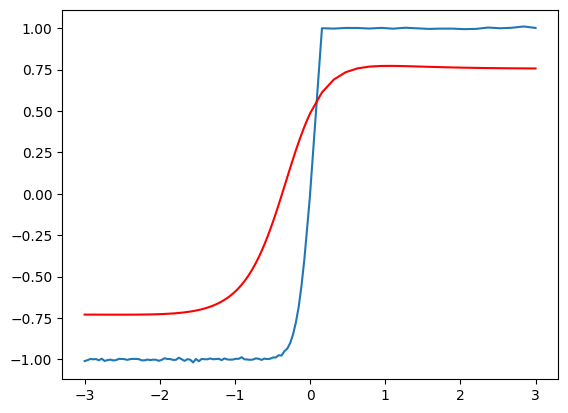

In [ ]:
predicted_ys = []
for train_x in x:
  input_layer.set_value(train_x)
  predicted_ys.append(output_layer.forward())

plt.plot(x, y, label="Original")
plt.plot(x, predicted_ys, color="red", label="Prediction")
plt.show()

In [ ]:
len(lossed_no), len(lossed_reg)

(7500, 7500)

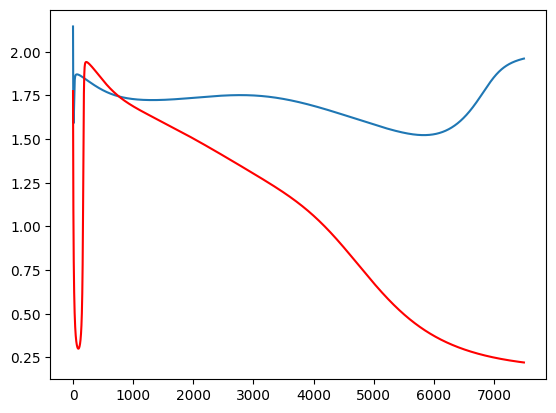

In [ ]:
epoch_nums = range(7_500)

plt.plot(epoch_nums, lossed_no, label="No reg")
plt.plot(epoch_nums, lossed_reg, color="red", label="Reg")
plt.show()

## Усложнение моделей и целевой функции

In [ ]:
1+1

2